# **FORMEL TRAINING MODEL**

## **LOADING DATA**

In [3]:
# Import dataset

file_score = "../DATAS/CleanALL_EHCVM_ML.csv"

## **IMPORTS LIBRARIES**

In [4]:
# Imports Libairies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import joblib

import warnings

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer, label_binarize
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold

from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score, mean_squared_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV 


In [5]:
# Import Modèles

from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

## **READ DATA**

In [6]:
df_score = pd.read_csv(file_score)
Form_score = df_score.copy()
Form_score

,mstat,rev_total_mois,age_grp,bancarise,a_assurance,logem,Stg_formel
0,Célibataire,279244.0,25-34,1,0,Locataire,1
1,Célibataire,0.0,0-17,0,0,Locataire,0
2,Célibataire,0.0,0-17,0,0,Locataire,0
3,Célibataire,0.0,0-17,0,0,Locataire,0
4,Marié(e),0.0,25-34,0,0,Locataire,0
...,...,...,...,...,...,...,...
64469,Célibataire,0.0,0-17,0,0,Proprietaire titre,0
64470,Célibataire,0.0,0-17,0,0,Proprietaire titre,0
64471,Célibataire,0.0,0-17,0,0,Proprietaire titre,0
64472,Célibataire,0.0,0-17,0,0,Proprietaire titre,0


In [7]:
Form_score.isna().sum()

mstat             0
rev_total_mois    0
age_grp           0
bancarise         0
a_assurance       0
logem             0
Stg_formel        0
dtype: int64

In [8]:
Form_score = Form_score.drop(['Stg_formel'], axis=1)
Form_score

,mstat,rev_total_mois,age_grp,bancarise,a_assurance,logem
0,Célibataire,279244.0,25-34,1,0,Locataire
1,Célibataire,0.0,0-17,0,0,Locataire
2,Célibataire,0.0,0-17,0,0,Locataire
3,Célibataire,0.0,0-17,0,0,Locataire
4,Marié(e),0.0,25-34,0,0,Locataire
...,...,...,...,...,...,...
64469,Célibataire,0.0,0-17,0,0,Proprietaire titre
64470,Célibataire,0.0,0-17,0,0,Proprietaire titre
64471,Célibataire,0.0,0-17,0,0,Proprietaire titre
64472,Célibataire,0.0,0-17,0,0,Proprietaire titre


## **COURBE KDE (Kernel Density Estimator) : Approximation of the probability density of each variable**

Differentes catégories


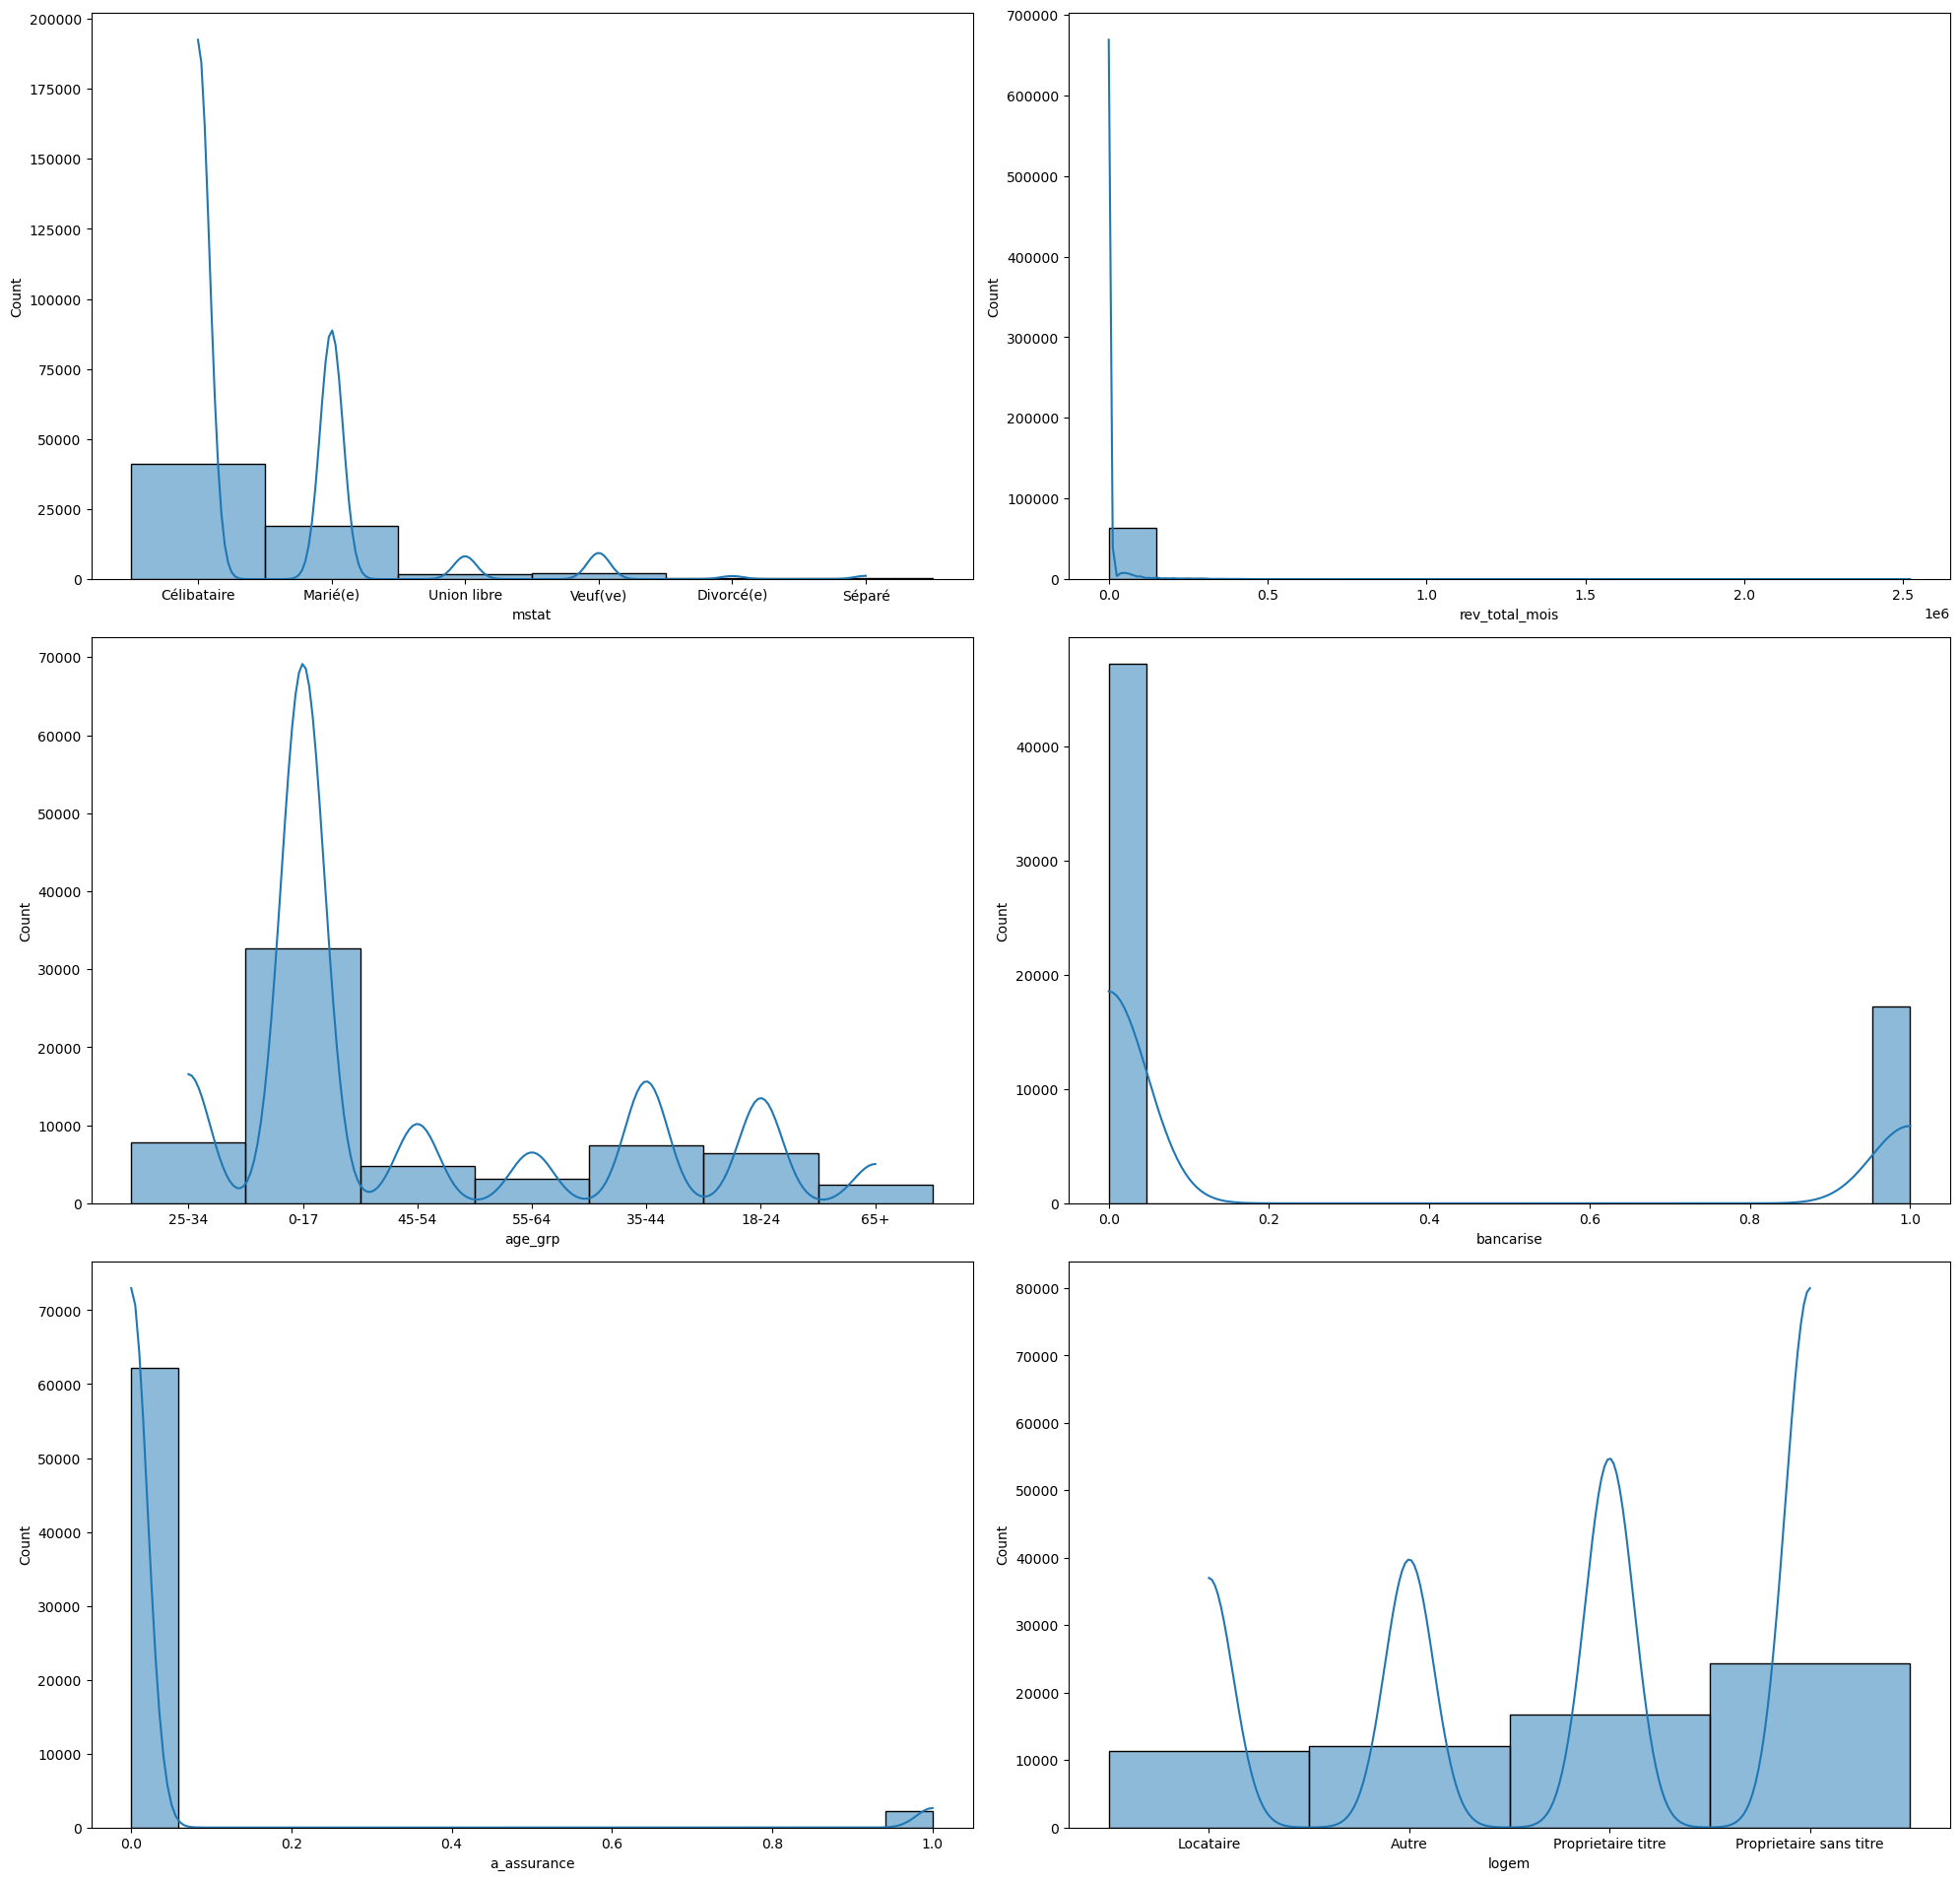

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
ax = ax.flatten()
i = 0
Form_score.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in Form_score.columns:
    sns.histplot(data = Form_score, x=col,kde = True ,ax = ax[i])
    i += 1
plt.tight_layout(rect=[0, 0, 1, 0.96])
print("Differentes catégories")
plt.show()

## **CREATION OF THE TARGET**

In [10]:

def score_inclusion_financiere(row):
    score = 0
       
    #print(f"\n---------------------Data {row.name}------------------\n")

    # Situation Matrimoniale (10 points)  ok
    if row['mstat'] == "Marié(e)":
        score += 10
    elif row['mstat'] == "Union libre":
        score += 8
    elif row['mstat'] == "Célibataire":
        score += 7
    elif row['mstat'] == "Veuf(ve)":
        score += 6
    elif row['mstat'] in ["Divorcé(e)", "Séparé"]:
        score += 4
    
    #print(f"1 - {score}")
    
    # Groupe d'Âge (12 points)   ok
    if row['age_grp'] == "18-24":
        score += 4
    elif row['age_grp'] == "65+":
        score += 7
    elif row['age_grp'] in ["25-34", "35-44", "45-54"]:
        score += 10
    elif row['age_grp'] == "55-64":
        score += 12
    
    #print(f"2 - {score}")
    
    # Bancarisation (20 points)   ok
    if row['bancarise'] == 1:
        score += 20
    elif row['bancarise'] == 0:
        score += 10

    #print(f"3 - {score}")
    
    # Assurance (10 points)   ok
    if row['a_assurance'] == 1:
        score += 10
    elif row['a_assurance'] == 0:
        score += 4

    #print(f"4 - {score}")

    # Logement (10 points)   ok
    if row['logem'] == "Proprietaire titre":
        score += 10
    elif row['logem'] == "Proprietaire sans titre":
        score += 8
    elif row['logem'] == "Locataire":
        score += 5

    #print(f"5 - {score}")

    # Revenu (20 points)   ok
    if (row['rev_total_mois'] >= 50000) and (row['rev_total_mois'] < 300000):
        score += 5
    elif (row['rev_total_mois'] >= 300000) and (row['rev_total_mois'] < 500000):
        score += 10
    elif (row['rev_total_mois'] >= 500000) and (row['rev_total_mois'] < 1000000):
        score += 15
    elif row['rev_total_mois'] >= 1000000:
        score += 20

    #print(f"6 - {score}")
    #print(f"\n---------------------------------------\n")

    return score


In [11]:
Form_score['Profil_Score'] = Form_score.apply(score_inclusion_financiere, axis=1)
print("-------------- FIN DE LA CREATION DU TARGET --------------")

-------------- FIN DE LA CREATION DU TARGET --------------


In [12]:
classes = Form_score['Profil_Score'].unique()
classes

array([51, 26, 39, 49, 46, 48, 40, 36, 32, 47, 63, 65, 60, 55, 21, 41, 31,
       62, 27, 25, 35, 50, 37, 56, 54, 43, 44, 53, 45, 38, 57, 30, 42, 52,
       58, 29, 59, 70, 33, 34, 28, 72, 61, 66, 77, 69, 67, 76, 75, 80, 73,
       64, 71, 68, 74, 24, 22])

In [13]:
Form_score['Profil_Score'].nunique()

57

In [14]:
Form_score

,mstat,rev_total_mois,age_grp,bancarise,a_assurance,logem,Profil_Score
0,Célibataire,279244.0,25-34,1,0,Locataire,51
1,Célibataire,0.0,0-17,0,0,Locataire,26
2,Célibataire,0.0,0-17,0,0,Locataire,26
3,Célibataire,0.0,0-17,0,0,Locataire,26
4,Marié(e),0.0,25-34,0,0,Locataire,39
...,...,...,...,...,...,...,...
64469,Célibataire,0.0,0-17,0,0,Proprietaire titre,31
64470,Célibataire,0.0,0-17,0,0,Proprietaire titre,31
64471,Célibataire,0.0,0-17,0,0,Proprietaire titre,31
64472,Célibataire,0.0,0-17,0,0,Proprietaire titre,31


## **LABELING OF VARIABLES**

In [15]:
label_encoders = {}

# Variables catégorielles à encoder
cat_cols = ['mstat', 'age_grp', 'logem']

for col in cat_cols:
    le = LabelEncoder()
    Form_score[col] = le.fit_transform(Form_score[col])
    label_encoders[col] = le
Form_score

,mstat,rev_total_mois,age_grp,bancarise,a_assurance,logem,Profil_Score
0,0,279244.0,2,1,0,1,51
1,0,0.0,0,0,0,1,26
2,0,0.0,0,0,0,1,26
3,0,0.0,0,0,0,1,26
4,2,0.0,2,0,0,1,39
...,...,...,...,...,...,...,...
64469,0,0.0,0,0,0,3,31
64470,0,0.0,0,0,0,3,31
64471,0,0.0,0,0,0,3,31
64472,0,0.0,0,0,0,3,31


In [16]:
# Afficher les mappings pour chaque variable
for col in cat_cols:
    le = label_encoders[col]
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"Mapping '{col}':")
    for k, v in mapping.items():
        print(f"  {k} -> {v}")
    print("-" * 30)

Mapping 'mstat':
  Célibataire -> 0
  Divorcé(e) -> 1
  Marié(e) -> 2
  Séparé -> 3
  Union libre -> 4
  Veuf(ve) -> 5
------------------------------
Mapping 'age_grp':
  0-17 -> 0
  18-24 -> 1
  25-34 -> 2
  35-44 -> 3
  45-54 -> 4
  55-64 -> 5
  65+ -> 6
------------------------------
Mapping 'logem':
  Autre -> 0
  Locataire -> 1
  Proprietaire sans titre -> 2
  Proprietaire titre -> 3
------------------------------


In [17]:
Form_score

,mstat,rev_total_mois,age_grp,bancarise,a_assurance,logem,Profil_Score
0,0,279244.0,2,1,0,1,51
1,0,0.0,0,0,0,1,26
2,0,0.0,0,0,0,1,26
3,0,0.0,0,0,0,1,26
4,2,0.0,2,0,0,1,39
...,...,...,...,...,...,...,...
64469,0,0.0,0,0,0,3,31
64470,0,0.0,0,0,0,3,31
64471,0,0.0,0,0,0,3,31
64472,0,0.0,0,0,0,3,31


### **Correlation Matrix**

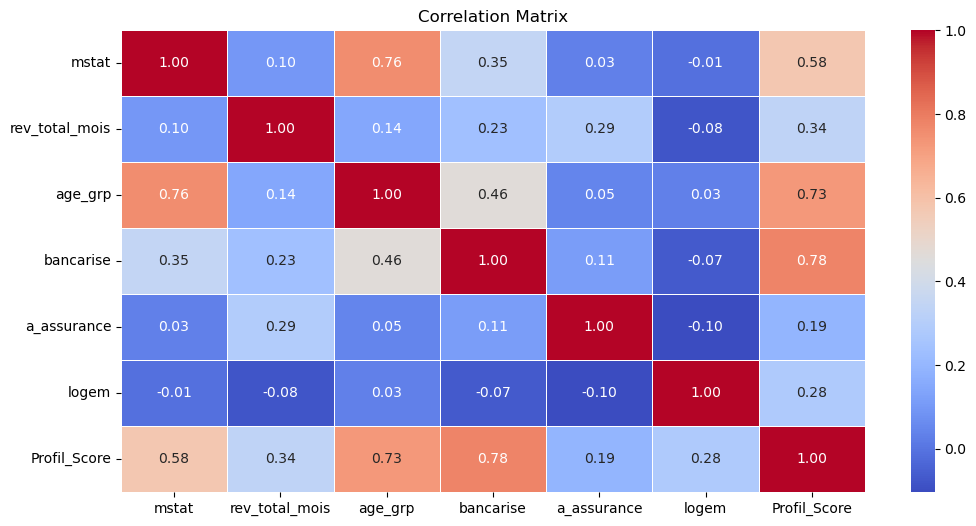

In [18]:
df_subset = Form_score
corr_matrix = df_subset.corr()
plt.figure(figsize = (12,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

#### Les méthodes de filtrage comme la corrélation ou le seuil de variance sont excellentes quand nous avons beaucoup de caractéristiques et voulons supprimer rapidement celles qui ne sont pas pertinentes et voir le comportement des caractérisques par rapport à la variable cible. Cependant, si nous voulons maximiser les performances du modèle et avoir les ressources de calcul, nous pourrions vouloir explorer des méthodes d'emballage comme RFE ou des méthodes intégrées comme Lasso. 

#### La matrice de correlation permet aussi d'observer les variables qui sont corrélées entre elles et celles qui ont un impact sur la variable cible. Ainsi l'on à une idée de comment maximiser les performances du modèle et optimiser à l'avance les erreurs possibles du modèle.

#### OBSERVATION : Les variables ne sont pas corrélées entre elles et à la variable cible. Pas de problème à ce niveau. 

## **SEPARATE THE FEATURES FROM THE TARGET**

In [19]:
# Separation des caractérisques et de la cible

X = Form_score.drop(columns=['Profil_Score'])
y = Form_score['Profil_Score']

In [20]:
X

,mstat,rev_total_mois,age_grp,bancarise,a_assurance,logem
0,0,279244.0,2,1,0,1
1,0,0.0,0,0,0,1
2,0,0.0,0,0,0,1
3,0,0.0,0,0,0,1
4,2,0.0,2,0,0,1
...,...,...,...,...,...,...
64469,0,0.0,0,0,0,3
64470,0,0.0,0,0,0,3
64471,0,0.0,0,0,0,3
64472,0,0.0,0,0,0,3


In [21]:
y

0        51
1        26
2        26
3        26
4        39
         ..
64469    31
64470    31
64471    31
64472    31
64473    54
Name: Profil_Score, Length: 64474, dtype: int64

## **SEPARATION OF TRAINING, VALIDATION AND TESTING**

In [22]:
features = ['mstat', 'age_grp', 'bancarise', 'a_assurance', 'logem', 'rev_total_mois']
target = 'Profil_Score'

In [23]:
# Données d'entrainement, validation et de test

# Séparation initiale train+val et test
X_train_val, X_test_n, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Séparation train et validation
X_train_n, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  
# 0.25 * 0.8 = 0.2 donc validation = 20%

# X_train_n, X_test_n, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train :{X_train_n.shape}")
print(f"y_train :{y_train.shape}")
print(f"X_val :{X_val.shape}")
print(f"y_val :{y_val.shape}")
print(f"X_test :{X_test_n.shape}")
print(f"y_test :{y_test.shape}")

X_train :(38684, 6)
y_train :(38684,)
X_val :(12895, 6)
y_val :(12895,)
X_test :(12895, 6)
y_test :(12895,)


In [24]:
X_train_n

,mstat,rev_total_mois,age_grp,bancarise,a_assurance,logem
31539,2,0.000,5,0,0,3
33348,0,0.000,0,0,1,0
43705,0,0.000,0,0,0,2
17811,0,0.000,0,0,0,2
22152,0,0.000,0,0,0,2
...,...,...,...,...,...,...
23,0,0.000,3,1,0,1
36203,2,0.000,2,1,0,3
52310,2,81118.133,2,1,0,1
2561,0,0.000,0,0,0,3


## **MODEL TRAINING PROCESS**

### **Choice The Best Model**

## **Ensemble Learning Algorithm**

### **BaggingRegressor with RandomForestRegressor**

In [25]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

In [26]:
bagging = BaggingRegressor(
    estimator=RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
bagging.fit(X_train_n, y_train)
y_pred_bag = bagging.predict(X_test_n)
print("Bagging RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_bag)))
print("Bagging R2:", r2_score(y_test, y_pred_bag))


Bagging RMSE: 1.6602752949552408
Bagging R2: 0.9728843334333793


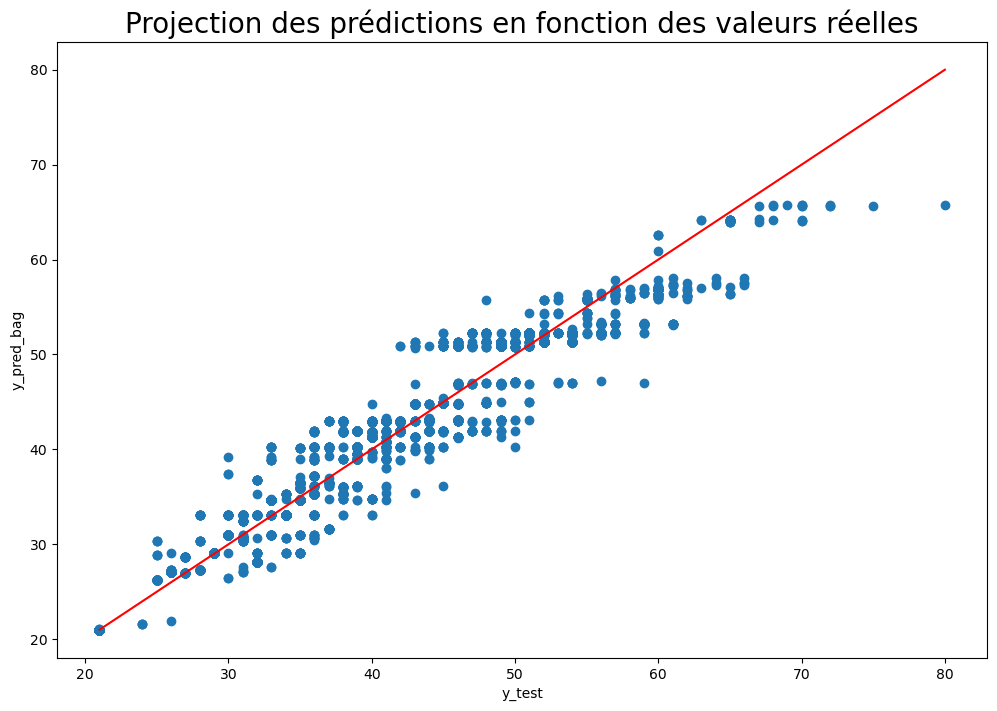

In [27]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_test, y_pred_bag)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r')
ax.set(xlabel='y_test', ylabel='y_pred_bag')
plt.title("Projection des prédictions en fonction des valeurs réelles", fontsize=20)
plt.show()

In [28]:
if hasattr(bagging, "feature_importances_"):
        importances = bagging.feature_importances_
        import_df = pd.DataFrame({'variable': features, 'importance': importances}).sort_values(by='importance', ascending=False)
        print("          Importance des variables :\n", import_df)
        plt.figure(figsize=(10, 6))
        plt.barh(import_df['variable'], import_df['importance'], color='steelblue')
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'📊 Importance des Variables', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

### **Boosting with GradientBoostingRegressor**

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

boosting1 = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
boosting1.fit(X_train_n, y_train)
y_pred_boost = boosting1.predict(X_test_n)
print("Boosting RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_boost)))
print("Boosting R2:", r2_score(y_test, y_pred_boost))

Boosting RMSE: 0.3187162159574219
Boosting R2: 0.9990007632580976


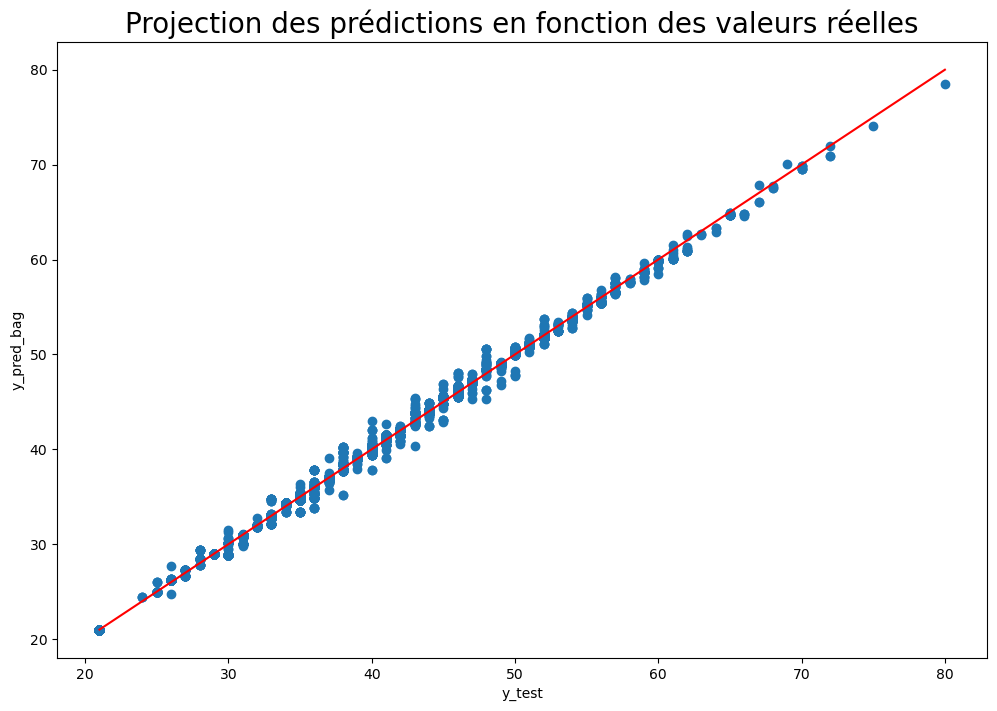

In [30]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_test, y_pred_boost)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r')
ax.set(xlabel='y_test', ylabel='y_pred_bag')
plt.title("Projection des prédictions en fonction des valeurs réelles", fontsize=20)
plt.show()

          Importance des variables :
          variable  importance
2       bancarise    0.636363
3     a_assurance    0.177656
5  rev_total_mois    0.114884
0           mstat    0.036832
1         age_grp    0.020891
4           logem    0.013374


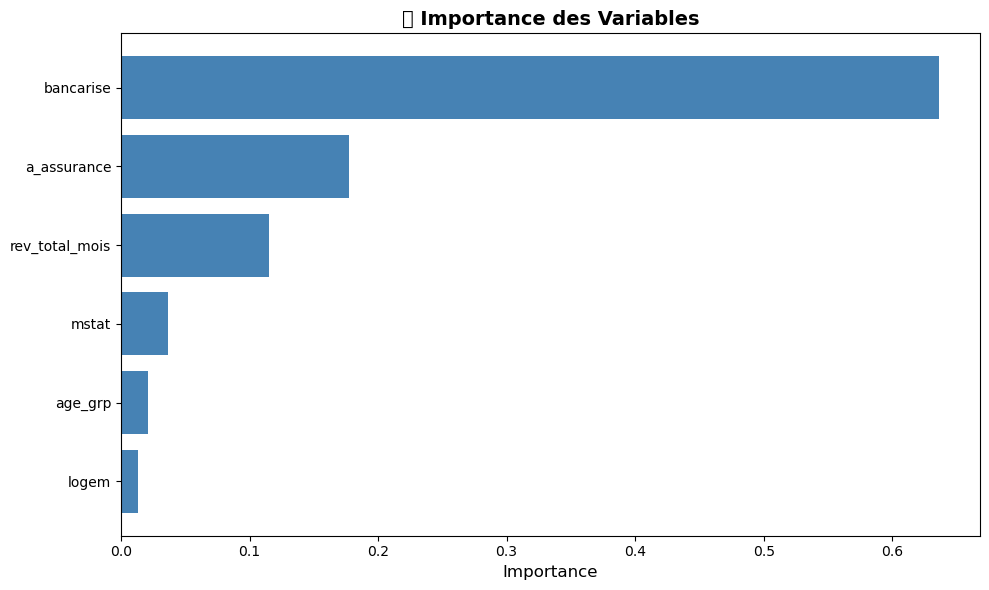

In [31]:
if hasattr(boosting1, "feature_importances_"):
        importances = boosting1.feature_importances_
        import_df = pd.DataFrame({'variable': features, 'importance': importances}).sort_values(by='importance', ascending=False)
        print("          Importance des variables :\n", import_df)
        plt.figure(figsize=(10, 6))
        plt.barh(import_df['variable'], import_df['importance'], color='steelblue')
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'📊 Importance des Variables', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

### **Vizualisation Models**

### **Search for the Hyperparameter of the Best Model**

In [ ]:
param_grid_gb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.7, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

grid_search_gb = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_gb,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_root_mean_squared_error'
)

grid_search_gb.fit(X_val, y_val)

print("🧠 Meilleurs paramètres GB:", grid_search_gb.best_params_)
print("📉 Score RMSE (CV):", -grid_search_gb.best_score_)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


### **Retraining the model with the hyperparameter**

In [ ]:
# Évaluation sur le test set avec meilleur modèle
best_params_boost = grid_search_gb.best_params_

In [ ]:
# GradientBoostingRegressor
best_boost = GradientBoostingRegressor(**best_params_boost, random_state=42)
best_boost.fit(X_train_n, y_train)

#### Features Importances and Performances of model

In [ ]:
if hasattr(best_boost, "feature_importances_"):
        importances = best_boost.feature_importances_
        import_df = pd.DataFrame({'variable': features, 'importance': importances}).sort_values(by='importance', ascending=False)
        print("          Importance des variables :\n", import_df)
        plt.figure(figsize=(10, 6))
        plt.barh(import_df['variable'], import_df['importance'], color='steelblue')
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'📊 Importance des Variables', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

In [ ]:
# Prédictions
y_pred_rboost = best_boost.predict(X_test_n)

# Scores
rmse_rboost = np.sqrt(mean_squared_error(y_test, y_pred_rboost))
r2_rboost = r2_score(y_test, y_pred_rboost)

print(f"GradientBoostingR - RMSE: {rmse_rboost}, R2: {r2_rboost}")

### **Evaluation with set test**

In [ ]:
dat = pd.DataFrame([{'mstat':0, 'rev_total_mois':279244.0, 'age_grp':2, 'empl_formel':1, 'bancarise':1, 'a_assurance':0, 'logem':1},
                    {'mstat':0, 'rev_total_mois':380000.00,   'age_grp':3, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':1},
                    {'mstat':2, 'rev_total_mois':0.00,    'age_grp':2, 'empl_formel':0, 'bancarise':1, 'a_assurance':0, 'logem':1},
                    {'mstat':2, 'rev_total_mois':200000.00,   'age_grp':3, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':1},
                    {'mstat':0, 'rev_total_mois':0.00,    'age_grp':0, 'empl_formel':0, 'bancarise':0, 'a_assurance':1, 'logem':1},
                    {'mstat':2, 'rev_total_mois':0.00,   'age_grp':4, 'empl_formel':0, 'bancarise':1, 'a_assurance':1, 'logem':1},
                    {'mstat':2, 'rev_total_mois':316733.34,   'age_grp':4, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':1}
    ])
dat

# dat['Profil_Score'] = [52, 75, 44, 70, 33, 62, 75]

In [ ]:
dat['Profil_Score'] = [52, 75, 44, 70, 33, 62, 75]
dat_p = dat.drop(columns=['Profil_Score'])
y_d = dat['Profil_Score']
y_d

In [ ]:
# Test intérieur du modèle extrait
datas = pd.DataFrame([
    {'mstat':0, 'rev_total_mois':0,        'age_grp':0, 'empl_formel':0, 'bancarise':0, 'a_assurance':0, 'logem':1, 'Profil_Score':28},
    {'mstat':1, 'rev_total_mois':50000,    'age_grp':1, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':2, 'Profil_Score':65},
    {'mstat':2, 'rev_total_mois':120000,   'age_grp':2, 'empl_formel':0, 'bancarise':1, 'a_assurance':0, 'logem':3, 'Profil_Score':78},
    {'mstat':3, 'rev_total_mois':250000,   'age_grp':3, 'empl_formel':1, 'bancarise':0, 'a_assurance':1, 'logem':0, 'Profil_Score':49},
    {'mstat':4, 'rev_total_mois':400000,   'age_grp':4, 'empl_formel':0, 'bancarise':1, 'a_assurance':1, 'logem':2, 'Profil_Score':85},
    {'mstat':5, 'rev_total_mois':30000,    'age_grp':5, 'empl_formel':1, 'bancarise':0, 'a_assurance':1, 'logem':3, 'Profil_Score':62},
    {'mstat':2, 'rev_total_mois':900000,   'age_grp':6, 'empl_formel':0, 'bancarise':1, 'a_assurance':0, 'logem':2, 'Profil_Score':91},
    {'mstat':0, 'rev_total_mois':150000,   'age_grp':1, 'empl_formel':0, 'bancarise':0, 'a_assurance':0, 'logem':0, 'Profil_Score':33},
    {'mstat':4, 'rev_total_mois':80000,    'age_grp':5, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':1, 'Profil_Score':72},
    {'mstat':1, 'rev_total_mois':1000000,  'age_grp':0, 'empl_formel':0, 'bancarise':0, 'a_assurance':0, 'logem':2, 'Profil_Score':38},
    {'mstat':5, 'rev_total_mois':290000,   'age_grp':3, 'empl_formel':1, 'bancarise':1, 'a_assurance':0, 'logem':3, 'Profil_Score':70},
    {'mstat':1, 'rev_total_mois':750000,   'age_grp':4, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':0, 'Profil_Score':82},
    {'mstat':2, 'rev_total_mois':330000,   'age_grp':2, 'empl_formel':0, 'bancarise':0, 'a_assurance':1, 'logem':2, 'Profil_Score':55},
    {'mstat':0, 'rev_total_mois':200000,   'age_grp':1, 'empl_formel':1, 'bancarise':0, 'a_assurance':1, 'logem':1, 'Profil_Score':60},
    {'mstat':5, 'rev_total_mois':50000,    'age_grp':6, 'empl_formel':1, 'bancarise':0, 'a_assurance':0, 'logem':3, 'Profil_Score':41},
    {'mstat':4, 'rev_total_mois':870000,   'age_grp':0, 'empl_formel':0, 'bancarise':1, 'a_assurance':1, 'logem':1, 'Profil_Score':78},
    {'mstat':3, 'rev_total_mois':20000,    'age_grp':1, 'empl_formel':1, 'bancarise':1, 'a_assurance':0, 'logem':0, 'Profil_Score':44},
    {'mstat':2, 'rev_total_mois':450000,   'age_grp':3, 'empl_formel':0, 'bancarise':1, 'a_assurance':1, 'logem':3, 'Profil_Score':80},
    {'mstat':0, 'rev_total_mois':35000,    'age_grp':5, 'empl_formel':1, 'bancarise':0, 'a_assurance':0, 'logem':2, 'Profil_Score':39},
    {'mstat':5, 'rev_total_mois':800000,   'age_grp':6, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':2, 'Profil_Score':95}
])
datas

In [ ]:
datas_p = datas.drop(columns=['Profil_Score'])
y_datas = datas['Profil_Score']
y_datas

#### 1er test

In [ ]:
pred_dat = best_boost.predict(dat_p)
pred_dat

In [ ]:
rms = np.sqrt(mean_squared_error(y_d, pred_dat))
r = r2_score(y_d, pred_dat)

print(f"RMSE sur test : {rms}")
print(f"R2 sur test : {r}")

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_d, pred_dat)
ax.plot([y_d.min(), y_d.max()], [y_d.min(), y_d.max()], color='r')
ax.set(xlabel='y_test', ylabel='y_pred')
plt.title("Projection des prédictions en fonction des valeurs réelles", fontsize=20)
plt.show()

#### 2e test

In [ ]:
pred_data = best_boost.predict(datas_p)
pred_data

In [ ]:
rms_data = np.sqrt(mean_squared_error(y_d, pred_data))
r_data = r2_score(y_d, pred_data)

print(f"RMSE sur test : {rms_data}")
print(f"R2 sur test : {r_data}")

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_datas, pred_xboost)
ax.plot([y_datas.min(), y_datas.max()], [y_datas.min(), y_datas.max()], color='r')
ax.set(xlabel='y_test', ylabel='y_pred')
plt.title("Projection des prédictions en fonction des valeurs réelles", fontsize=20)
plt.show()

### **RESUME**

## **MODEL DEPLOYMENT: EXTRACTION**